In [ ]:
import pandas as pd
import glob
import os
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# 1. Call for merged data

In [ ]:
calming_df = pd.read_csv('Calming_Merged_feature.csv')
vexing_df = pd.read_csv('Vexing_Merged_feature.csv')
music_df = pd.read_csv('Music_Merged_features.csv')

In [ ]:
# Drop the 'Unnamed: 0' column if it exists in calming_df and vexing_df
if 'Unnamed: 0' in calming_df.columns:
    calming_df = calming_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in vexing_df.columns:
    vexing_df = vexing_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0.1' in music_df.columns:
    music_df = music_df.drop(columns=['Unnamed: 0.1'])
if 'Unnamed: 0' in music_df.columns:
    music_df = music_df.drop(columns=['Unnamed: 0'])

In [ ]:
calming_df.head()

,n_back,Response_Time,condition,subject_id,BlockNumber,TrialInBlock,Correct,BVP_mean,BVP_std,HR_mean,...,ECG_mean,ECG_std,EMG_mean,EMG_std,RESP_mean,RESP_std,PPG_mean,PPG_std,SKT_mean,SKT_std
0,1,0.0,Calming,Subject4,1,1,0,-2.751331,5.453607,70.375,...,0.010924,0.195181,-0.002213,0.017522,-6.161784,0.105731,0.050346,0.024017,22.968318,0.000834
1,1,838.0,Calming,Subject4,1,2,1,4.456672,0.879887,69.615,...,0.010689,0.192964,-0.002241,0.017178,-6.033325,0.126568,0.050484,0.019253,22.968283,0.000822
2,1,374.0,Calming,Subject4,1,3,1,4.285210,0.740332,68.810,...,0.017447,0.221070,-0.002368,0.018552,-6.090992,0.086868,0.050917,0.020832,22.968333,0.000821
3,1,405.0,Calming,Subject4,1,4,1,-2.634205,2.918769,68.000,...,0.000513,0.216476,-0.002110,0.020708,-5.981885,0.137434,0.046472,0.021422,22.968352,0.000817
4,1,39.0,Calming,Subject4,1,5,1,0.772251,0.211038,67.205,...,0.006566,0.199935,-0.002105,0.022657,-6.062608,0.227627,0.048821,0.016176,22.968353,0.000816


# 2. Data splitting

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

def split_data(df, model_predicting = 'n_back'):
  '''
  In this function, we will split the data into training dataset, validation dataset, and testing dataset
  Args:
  df: Dataframe of raw data
  model_predicting: [str] indicating which model we are trying to split for
  '''

  if model_predicting == 'n_back':
    df_filtered = df[df['n_back'] != 'rest'].copy()
    y = df_filtered['n_back'].astype(int).map({1: 0, 3: 1})
    columns_to_drop = [
        'n_back', 'subject_id', 'BlockNumber', 'TrialInBlock',
        'Session', 'Block', 'Trial', 'task' # These are from empatica_df, might not exist in merged df
    ]
    # Ensure only existing columns are dropped
    final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    X = df_filtered.drop(columns=final_columns_to_drop)
    # One-hot encode 'condition' columns
    X = pd.get_dummies(X, columns=['condition'], drop_first=True)

  elif model_predicting == 'condition':
    df_filtered = df[df['n_back'] != 'rest'].copy()
    y = df_filtered['condition'].map({'calming': 0, 'vexing': 1})
    columns_to_drop = ['BlockNumber', 'TrialInBlock', 'subject_id', 'condition', 'task', 'n_back']

    final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    X = df_filtered.drop(columns=final_columns_to_drop)

  groups = df_filtered['subject_id']

  # Split 1: Create the Test set (10% of subjects)
  gss_test = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
  train_val_idx, test_idx = next(gss_test.split(X, y, groups))

  X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
  y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
  groups_train_val = groups.iloc[train_val_idx] # Get the subject list for the 90%

  # Split 2: Create the Validation set (10% of total)
  # We take 10% from the remaining 90% (0.10 / 0.90 = ~0.111)
  val_split_size = 0.10 / 0.90
  gss_valid = GroupShuffleSplit(n_splits=1, test_size=val_split_size, random_state=42)
  train_idx, valid_idx = next(gss_valid.split(X_train_val, y_train_val, groups_train_val))

  # Create the final sets
  X_train, X_valid = X_train_val.iloc[train_idx], X_train_val.iloc[valid_idx]
  y_train, y_valid = y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]

  print("\n Split Verification (80/10/10)")
  print(f"Total rows in X_train: {len(X_train)} (~80%)")
  print(f"Total rows in X_valid: {len(X_valid)} (~10%)")
  print(f"Total rows in X_test:  {len(X_test)} (~10%)")

  print(f"\nTraining subjects:   {groups_train_val.iloc[train_idx].unique()}")
  print(f"Validation subjects: {groups_train_val.iloc[valid_idx].unique()}")
  print(f"Test subjects:       {groups.iloc[test_idx].unique()}")

  # Check for any overlap (should be empty sets)
  train_subs = set(groups_train_val.iloc[train_idx].unique())
  valid_subs = set(groups_train_val.iloc[valid_idx].unique())
  test_subs = set(groups.iloc[test_idx].unique())

  print(f"\nOverlap Train/Valid: {train_subs.intersection(valid_subs)}")
  print(f"Overlap Train/Test:  {train_subs.intersection(test_subs)}")
  print(f"Overlap Valid/Test:  {valid_subs.intersection(test_subs)}")

  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test = split_data(calming_df)
vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test = split_data(vexing_df)


 Split Verification (80/10/10)
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()

 Split Verification (80/10/10)
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject6' 'Subject8' 'Subject11']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()


In [ ]:
calm_y_train.head()

,n_back
352,0
353,0
354,0
355,0
356,0


# 3. Feature selection

In [ ]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_all_features_probability_trend(X_df, y_df, n_bins=10,
                                        title_prefix="Feature vs. Target (Probability/Trend)",
                                        save = False):
    """
    Plots the probability/trend plot for each numerical feature in X_df against
    a binary target variable y_df.
    Shows the proportion of target=1 in each bin of the feature.

    Args:
        X_df (pd.DataFrame): DataFrame containing the features.
        y_df (pd.Series or pd.DataFrame): Series or DataFrame containing the
        binary target variable (0/1).
        n_bins (int): Number of bins to divide each feature into.
        title_prefix (str): Prefix for the plot titles.
    """
    # Ensure y_df is a Series
    if isinstance(y_df, pd.DataFrame):
        if y_df.shape[1] > 1:
            print("Warning: y_df has multiple columns. Using the first column for plotting.")
        y_series = y_df.iloc[:, 0]
    else:
        y_series = y_df

    num_features = X_df.shape[1]
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(X_df.columns):
        # Bin the feature
        bins = pd.qcut(X_df[column], q=n_bins, duplicates='drop')  # quantile-based bins
        prob_df = pd.DataFrame({'feature_bin': bins, 'target': y_series})
        prob_df = prob_df.groupby('feature_bin')['target'].mean().reset_index()  # probability of 1 in each bin

        # Plot probability trend
        sns.lineplot(x=prob_df['feature_bin'].astype(str), y=prob_df['target'], marker='o', ax=axes[i])
        axes[i].set_title(f"{title_prefix}: {column}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("P(Target=1)")
        axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save == True:
      plt.savefig("probability_feature.png")
    plt.show()


In [ ]:
def feature_engineering(X_df, y_df, drop_threshold):
  '''
  This function returns a list of features that have correlation > threshold
  Args:
  X_df: X training dataframe
  y_df: y training dataframe

  Returns:
  X_df_feature_engineering: list of index
  '''
  # Computing the correlation of each feature against the label 'n-back'
  X_df_feature_engineering = X_df.corrwith(y_df)

  print("\nFeature correlations:")
  print(abs(X_df_feature_engineering).sort_values(ascending=False))

  # Dropping all features that have correlation < threshold
  X_df_feature_engineering = X_df_feature_engineering[abs(X_df_feature_engineering) > drop_threshold]

  print("\nSelecting features that have correlation > {} with n-back label".format(drop_threshold))
  print(X_df_feature_engineering)
  print(f"\n{'='*40}")
  return X_df_feature_engineering.index.to_list()

### N-back Prediction analysis

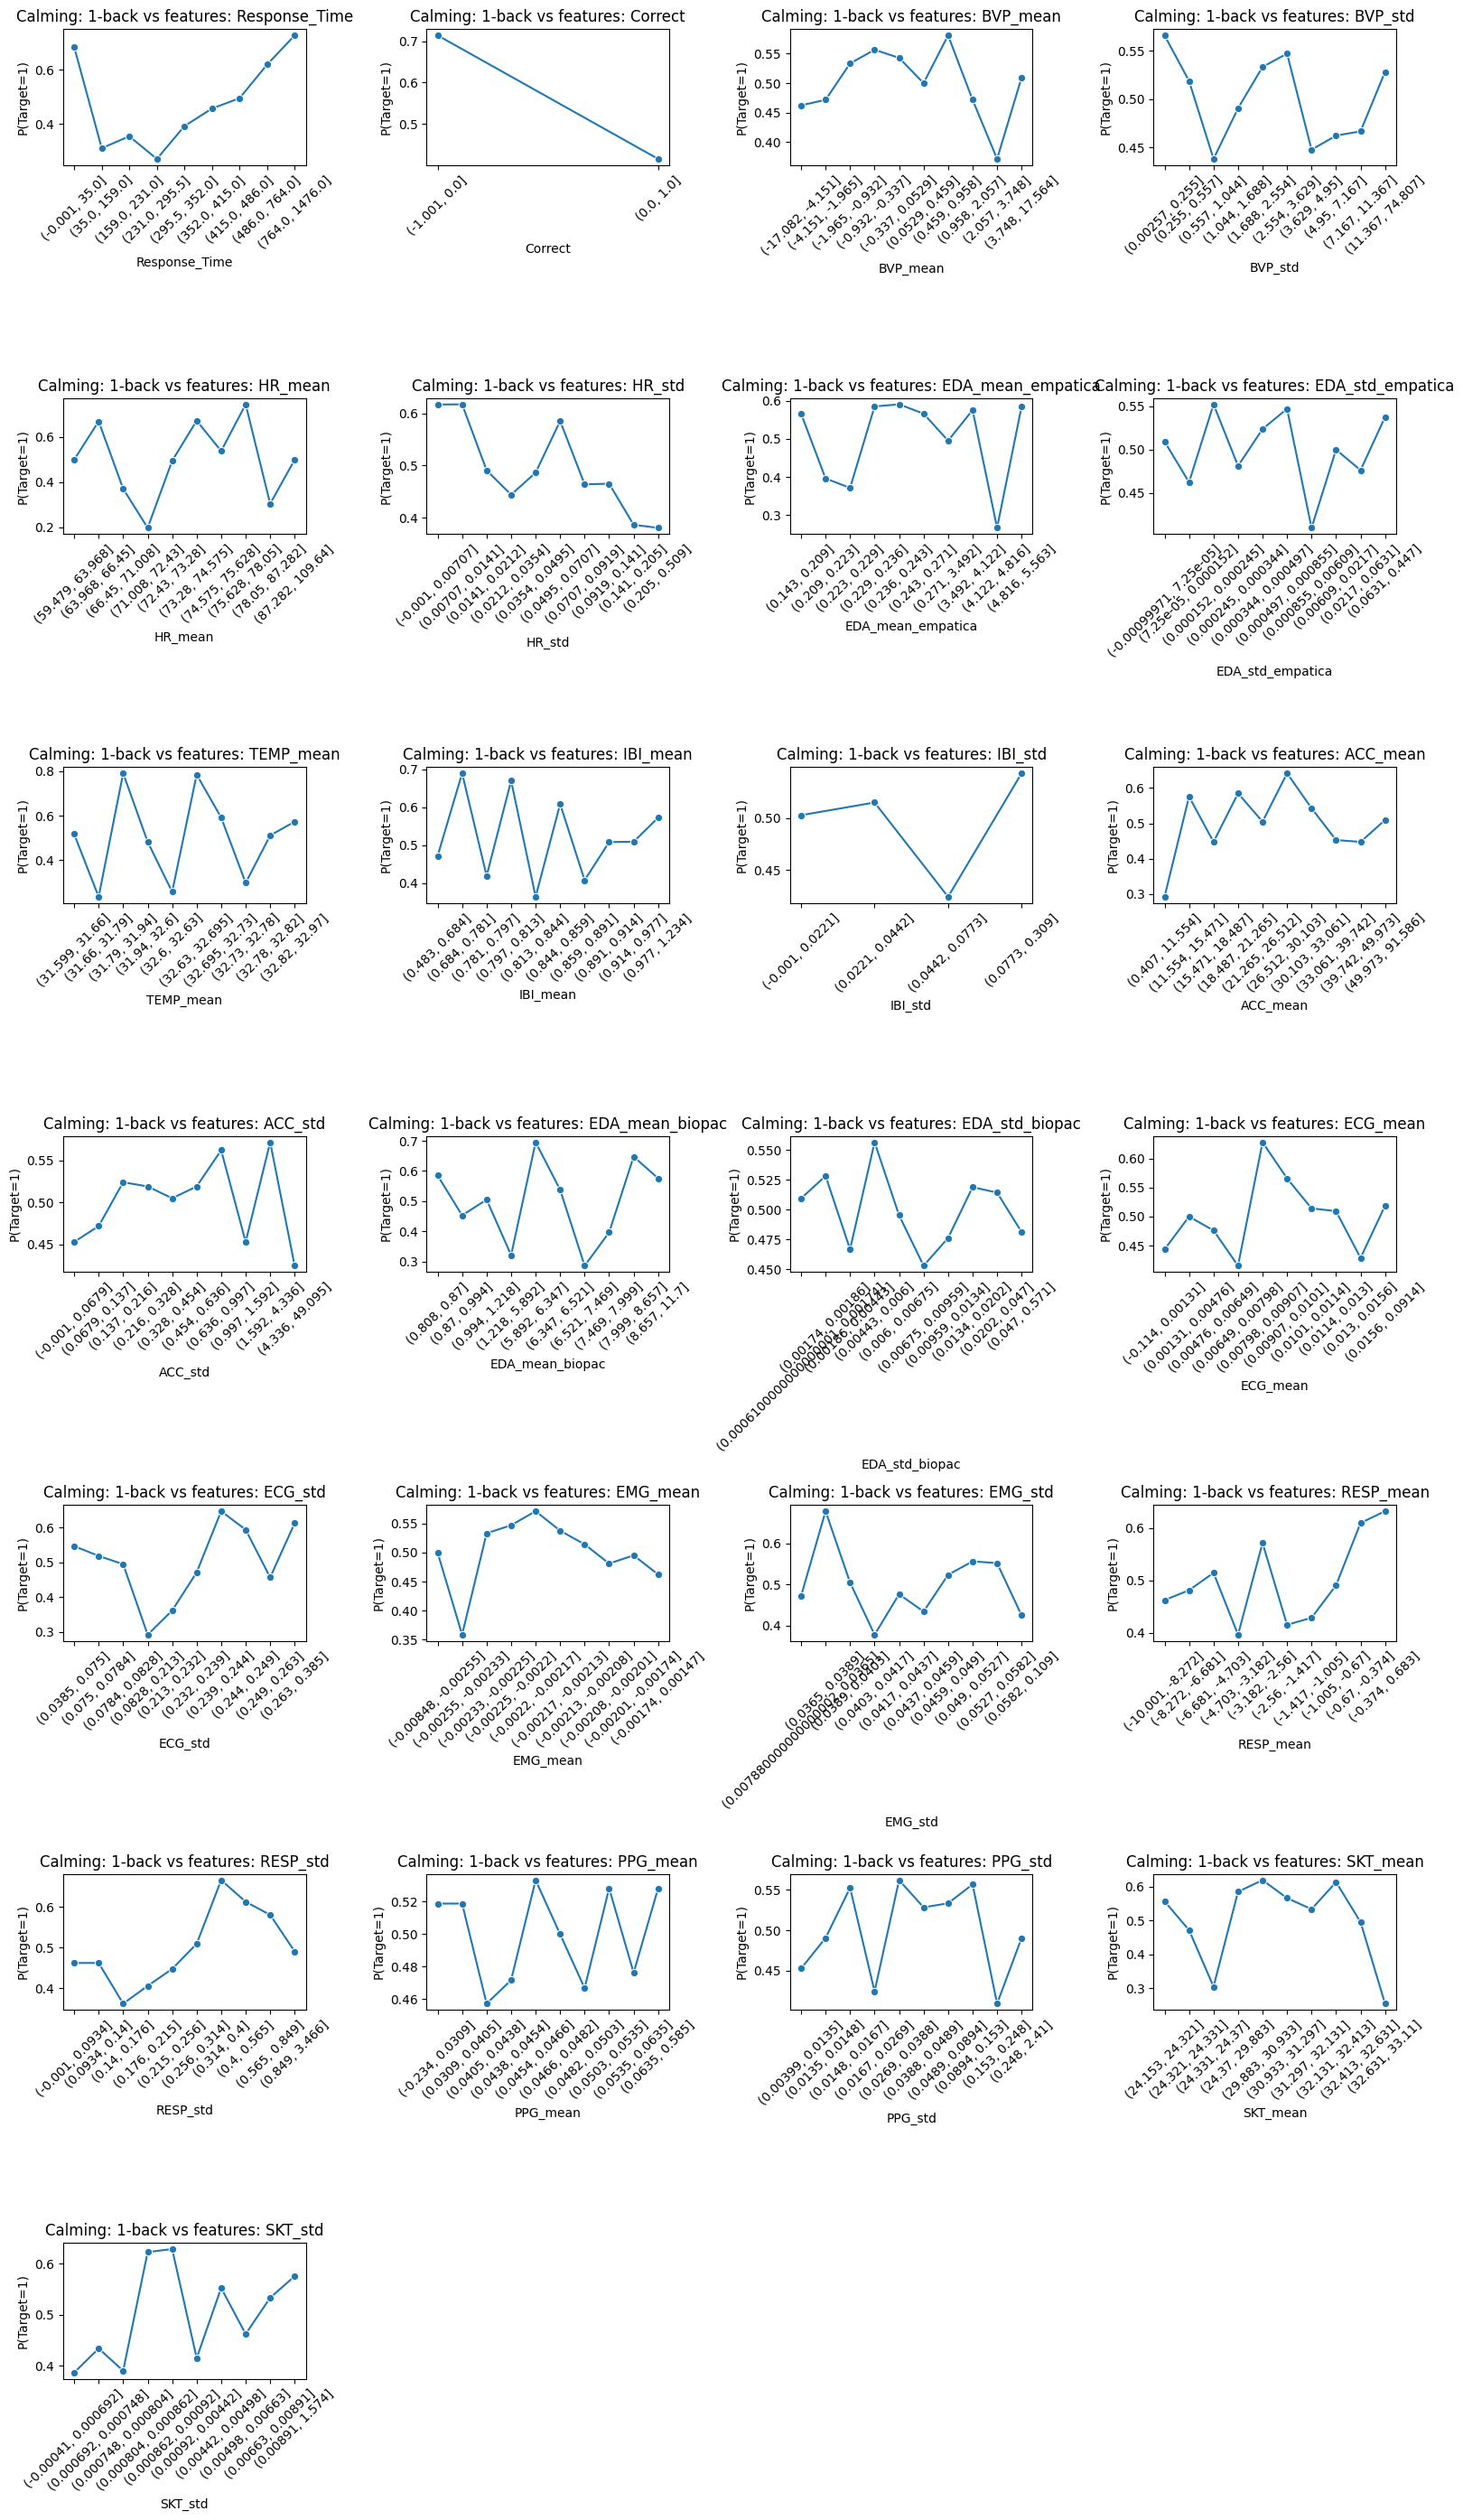

In [ ]:
# Plot features bins values against probability of 3_back value = 1
plot_all_features_probability_trend(calm_X_train, calm_y_train, title_prefix="Calming: 1-back vs features", save = True)

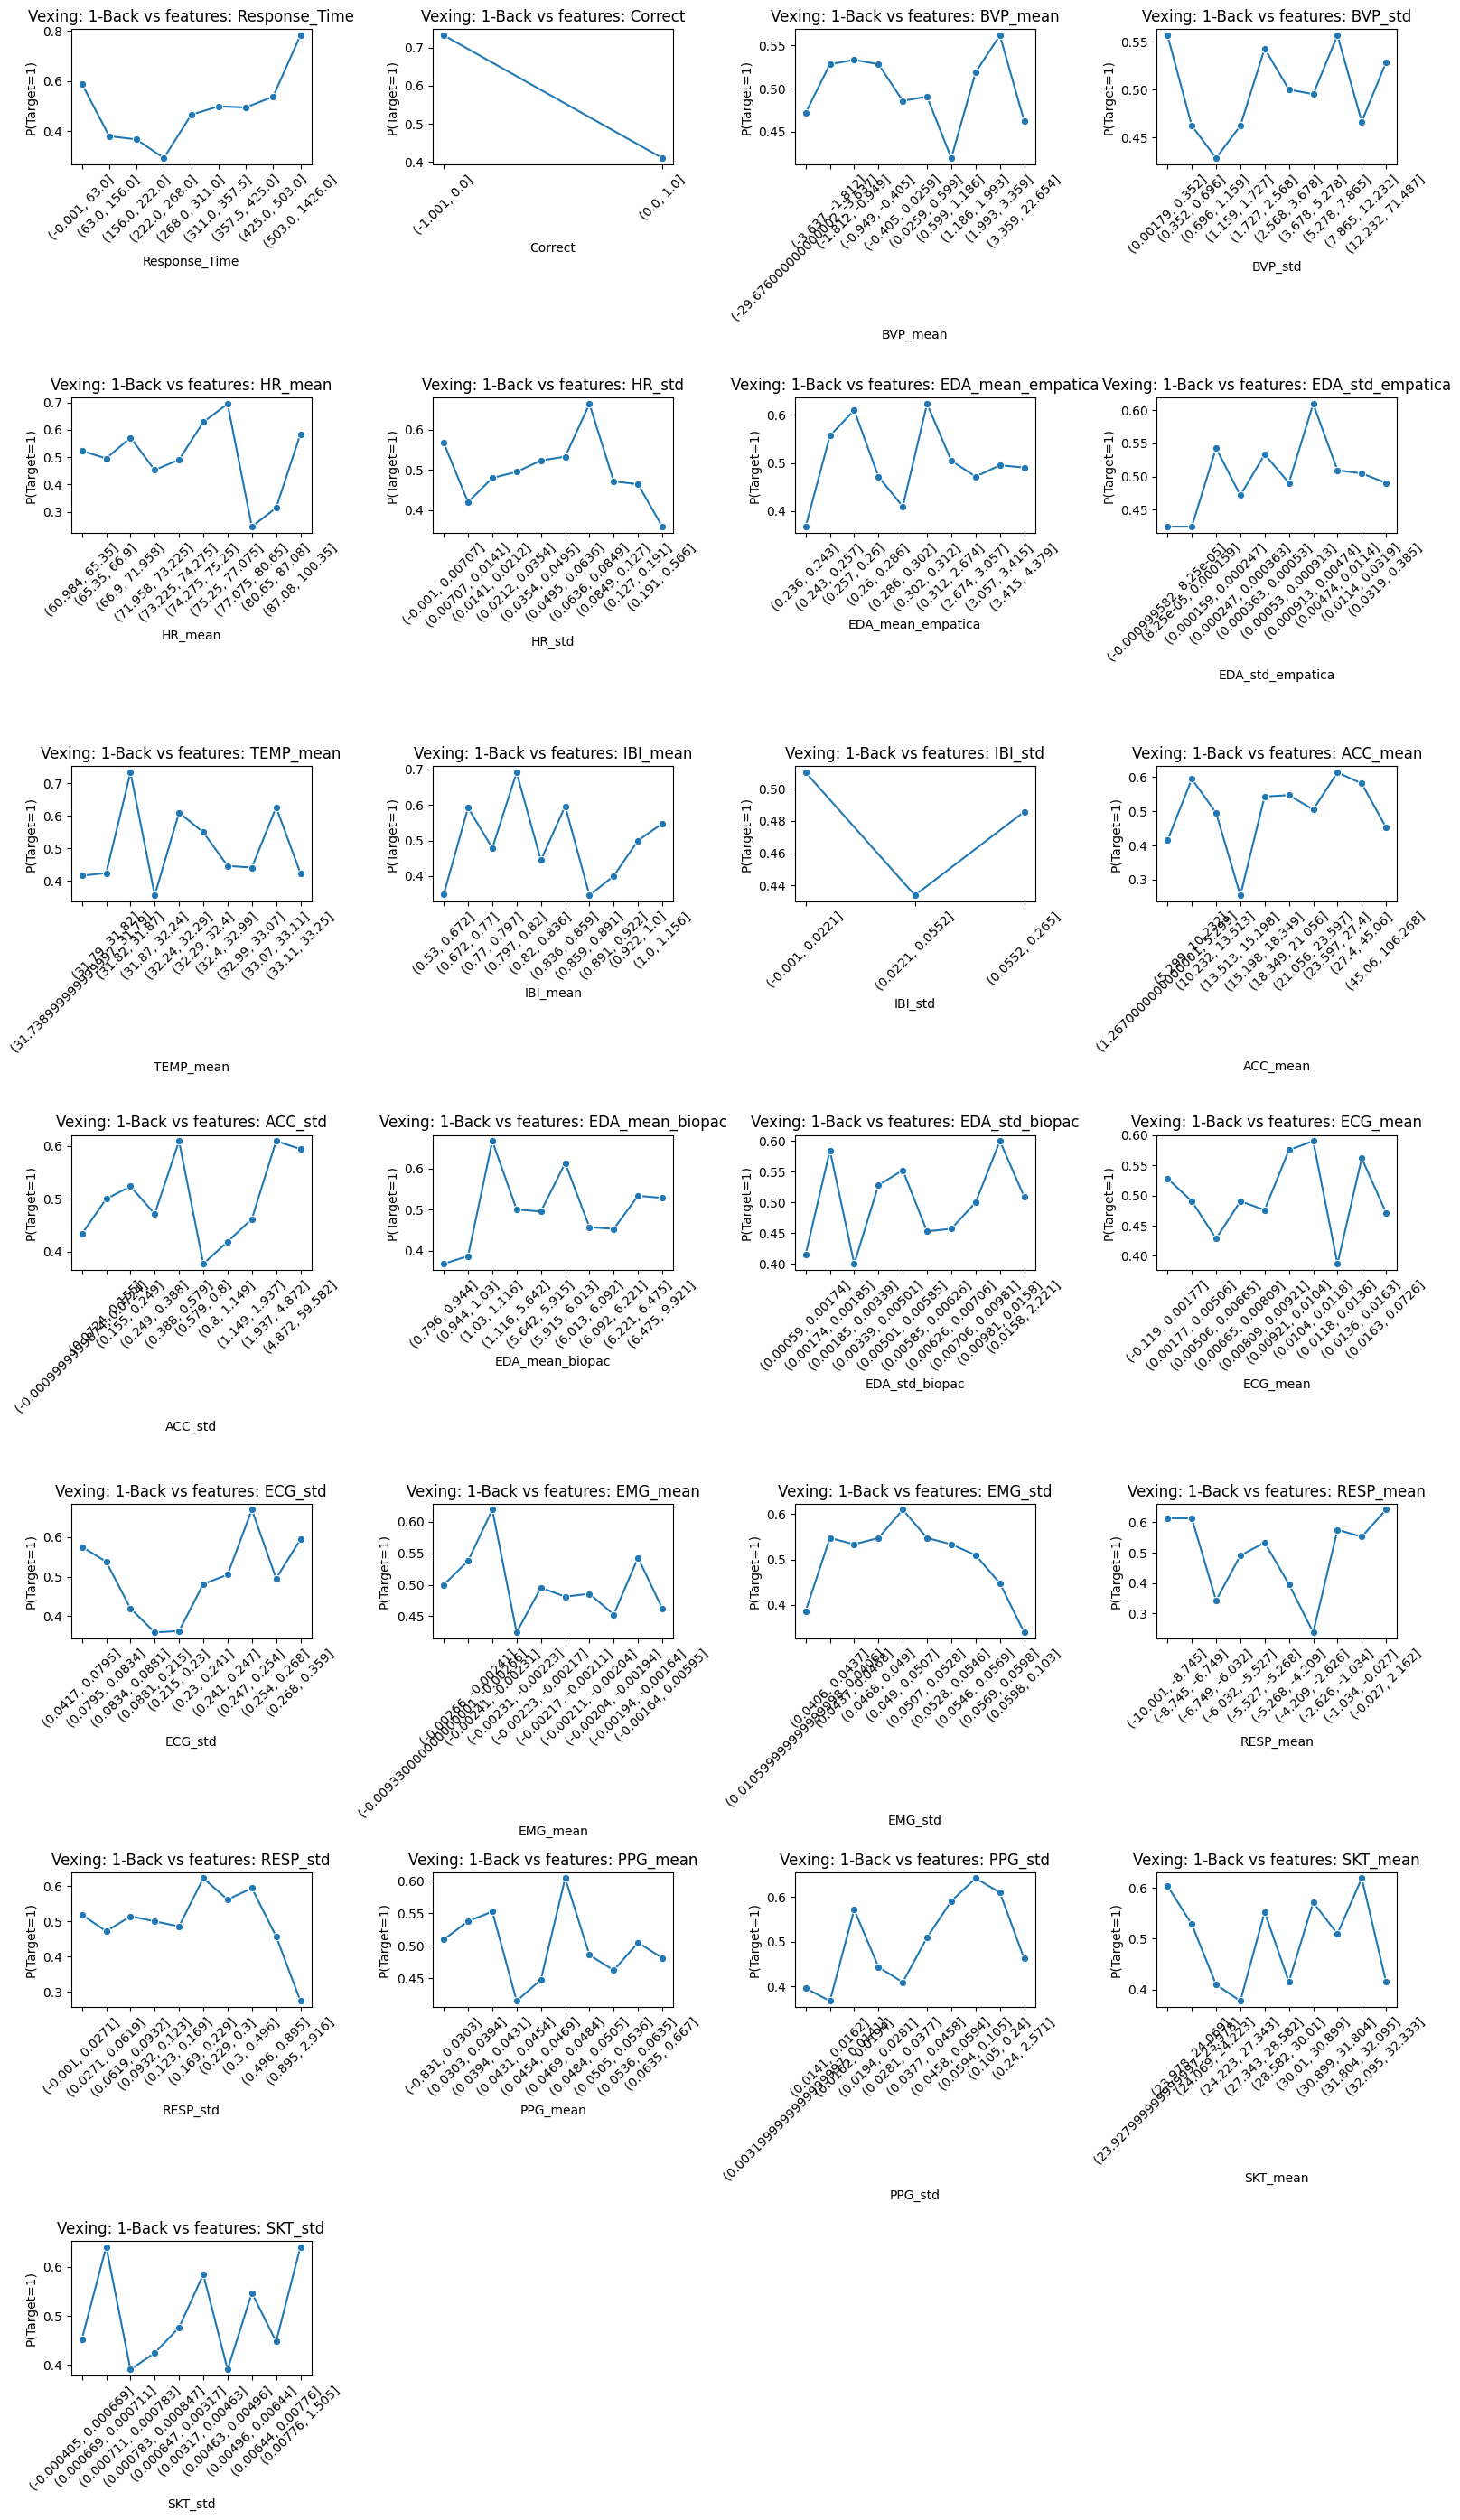

In [ ]:
# Plot features bins values against probability of 3_back value = 1
plot_all_features_probability_trend(vex_X_train, vex_y_train, title_prefix="Vexing: 1-Back vs features", save = True)

In [ ]:
calm_X_train_FE = feature_engineering(calm_X_train, calm_y_train, 0.05)
vex_X_train_FE = feature_engineering(vex_X_train, vex_y_train, 0.03)


Feature correlations:
Correct              0.246588
HR_std               0.124619
Response_Time        0.107886
RESP_mean            0.059623
RESP_std             0.047054
SKT_std              0.039030
ECG_std              0.038174
EDA_std_empatica     0.032715
ACC_std              0.032237
EDA_std_biopac       0.029649
PPG_mean             0.028711
ECG_mean             0.026279
EMG_std              0.023868
BVP_std              0.022212
IBI_std              0.018356
TEMP_mean            0.018070
PPG_std              0.017382
SKT_mean             0.015683
IBI_mean             0.015456
EDA_mean_biopac      0.014946
HR_mean              0.011025
EMG_mean             0.009455
EDA_mean_empatica    0.006749
BVP_mean             0.004331
ACC_mean             0.003182
dtype: float64

Selecting features that have correlation > 0.05 with n-back label
Response_Time    0.107886
Correct         -0.246588
HR_std          -0.124619
RESP_mean        0.059623
dtype: float64


Feature correlations:
Co

In [ ]:
calm_X_retrain = calm_X_train[calm_X_train_FE]
vex_X_retrain = vex_X_train[vex_X_train_FE]

In [ ]:
calm_X_revalid = calm_X_valid[calm_X_train_FE]
vex_X_revalid = vex_X_valid[vex_X_train_FE]

calm_X_retest = calm_X_test[calm_X_train_FE]
vex_X_retest = vex_X_test[vex_X_train_FE]

### Music Condition Prediction

In [ ]:
condition_X_train, condition_X_valid, condition_X_test, condition_y_train, condition_y_valid, condition_y_test = split_data(music_df, model_predicting='condition')


 Split Verification (80/10/10)
Total rows in X_train: 2112 (~80%)
Total rows in X_valid: 704 (~10%)
Total rows in X_test:  704 (~10%)

Training subjects:   ['Subject6' 'Subject11' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()


In [ ]:
condition_X_train.head()

,Response_Time,Correct,BVP_mean,BVP_std,HR_mean,HR_std,EDA_mean_empatica,EDA_std_empatica,TEMP_mean,IBI_mean,...,ECG_mean,ECG_std,EMG_mean,EMG_std,RESP_mean,RESP_std,PPG_mean,PPG_std,SKT_mean,SKT_std
704,0.0,0,-6.866983,4.143577,96.725,0.431335,0.143731,0.001510,31.62,0.484397,...,0.009592,0.239157,-0.002297,0.038816,-3.499566,0.205391,0.047063,0.014187,24.327730,0.004617
705,433.0,1,3.477187,28.346596,95.505,0.318198,0.143893,0.001298,31.61,0.484397,...,0.013199,0.246549,-0.002148,0.039642,-3.559666,0.161183,0.044943,0.013120,24.321215,0.000695
706,395.0,1,-0.394832,5.612661,94.870,0.212132,0.146725,0.000283,31.61,0.484397,...,0.008850,0.249883,-0.002393,0.040568,-3.513272,0.143495,0.046373,0.014130,24.314822,0.004861
707,36.0,1,1.458330,5.280786,94.275,0.205061,0.148449,0.000140,31.60,0.484397,...,0.012318,0.245407,-0.002095,0.039658,-3.411230,0.211652,0.044943,0.012395,24.311302,0.000738
708,453.0,1,0.124669,3.443051,93.725,0.205061,0.149334,0.001259,31.62,0.484397,...,0.002701,0.204481,-0.002177,0.033003,-3.488964,0.130214,0.046983,0.016080,24.311252,0.000733


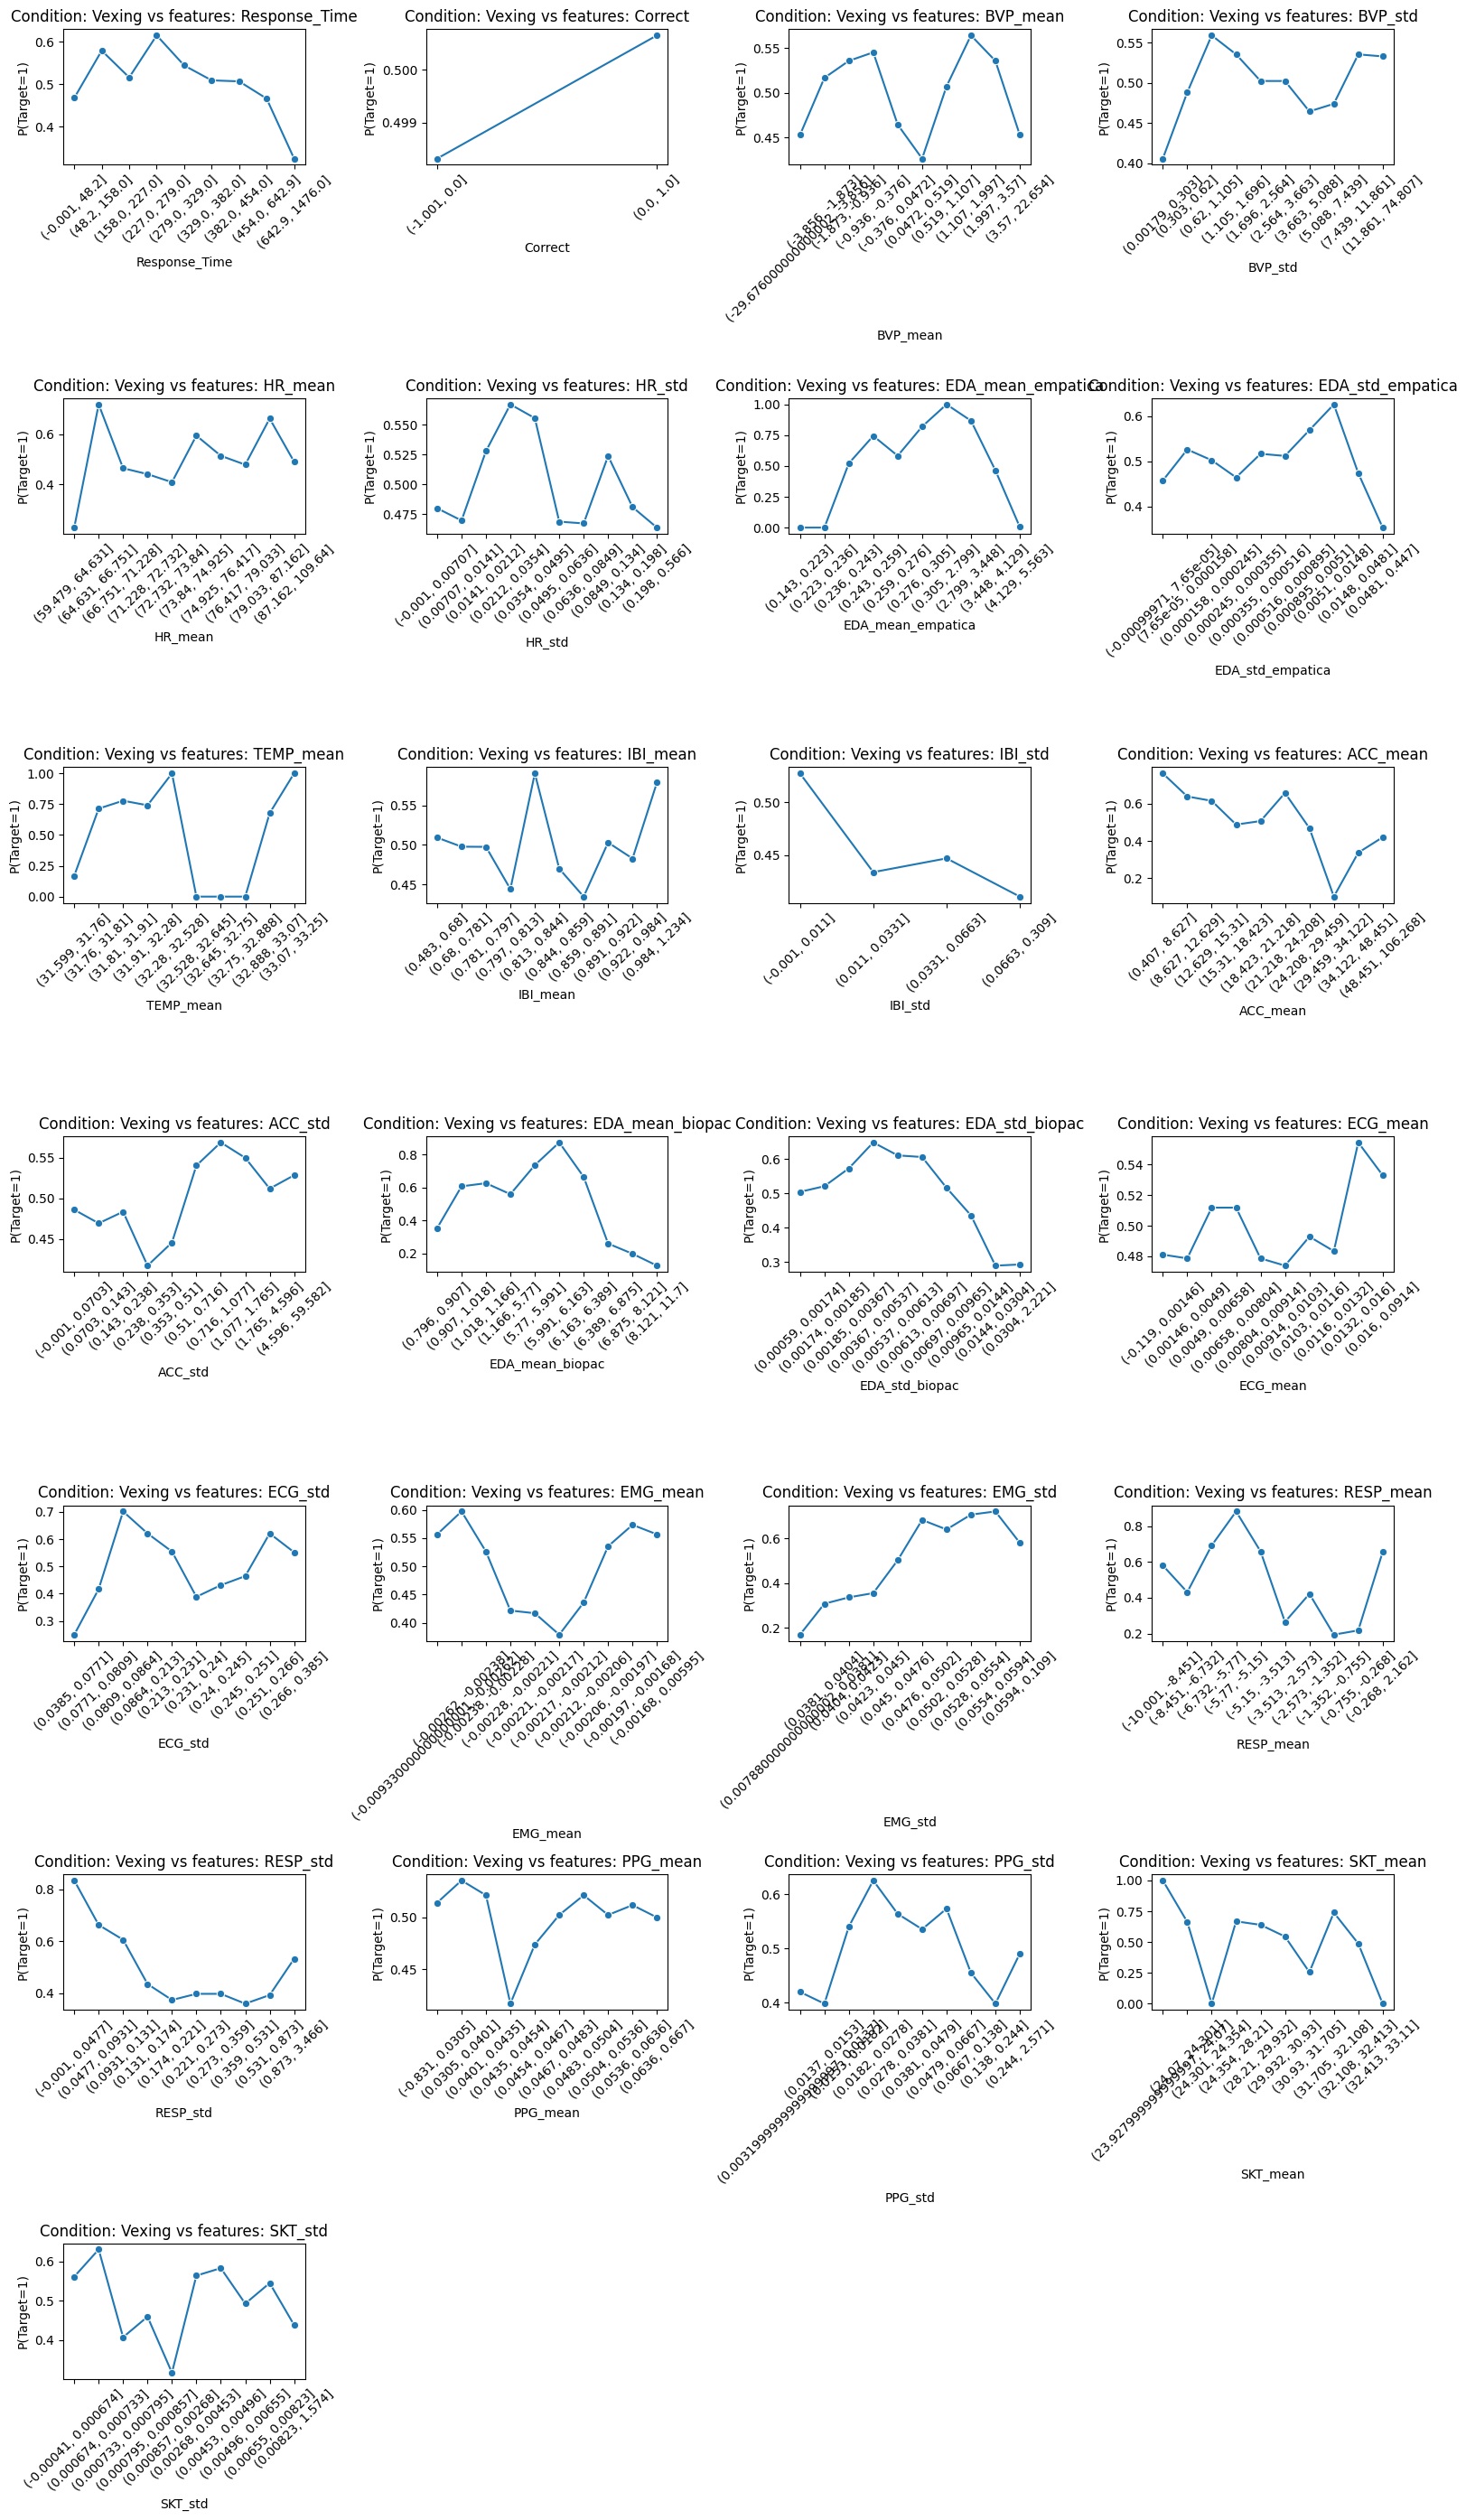

In [ ]:
# Plot of all features bins values against their probability of condition = True
plot_all_features_probability_trend(condition_X_train, condition_y_train, title_prefix="Condition: Vexing vs features")

In [ ]:
condition_FE = feature_engineering(condition_X_train, condition_y_train, 0.05)


Feature correlations:
EMG_std              0.264050
ACC_mean             0.214605
RESP_mean            0.179511
SKT_mean             0.149297
EDA_mean_biopac      0.127050
EDA_mean_empatica    0.102751
EDA_std_empatica     0.097433
Response_Time        0.094664
EDA_std_biopac       0.091782
IBI_std              0.082228
RESP_std             0.075936
ACC_std              0.046023
IBI_mean             0.040558
HR_mean              0.038973
PPG_std              0.038420
BVP_std              0.018291
ECG_std              0.017857
ECG_mean             0.016256
Correct              0.016251
HR_std               0.010015
SKT_std              0.007220
PPG_mean             0.005666
BVP_mean             0.002152
EMG_mean             0.001151
TEMP_mean            0.000996
dtype: float64

Selecting features that have correlation > 0.05 with n-back label
Response_Time       -0.094664
EDA_mean_empatica   -0.102751
EDA_std_empatica    -0.097433
IBI_std             -0.082228
ACC_mean            -0.21

In [ ]:
condition_X_train_FE = condition_X_train[condition_FE]
condition_X_valid_FE = condition_X_valid[condition_FE]
condition_X_test_FE = condition_X_test[condition_FE]

In [ ]:
print(condition_y_train.value_counts(normalize=True) * 100)
print(condition_y_valid.value_counts(normalize=True) * 100)
print(condition_y_test.value_counts(normalize=True) * 100)


condition
0    50.0
1    50.0
Name: proportion, dtype: float64
condition
1    50.0
0    50.0
Name: proportion, dtype: float64
condition
1    50.0
0    50.0
Name: proportion, dtype: float64


# 4. MLP classifier

## N-back prediction (Cognitive Load)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier

def MLPC_train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test, optimizing_model = False):

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)

  X_valid_scaled = scaler.transform(X_valid)
  X_test_scaled = scaler.transform(X_test)

  print("Feature scaling complete.")

  ############## OPTIMIZATION CODE - Below #####################
  if optimizing_model == True:
    pass

  ############## OPTIMIZING CODE - Complete ###################

  nn_model = MLPClassifier(hidden_layer_sizes=(50, 50), early_stopping = True,
                           alpha=0.01, max_iter= 300,
                           random_state = 42)

  # Train the model
  print("Training the Neural Network...")
  nn_model.fit(X_train_scaled, y_train)
  print("Training complete.")

  # TRAINING EVALUATION
  y_pred_train = nn_model.predict(X_train_scaled)
  train_acc = accuracy_score(y_train, y_pred_train)
  print("Training Accuracy:", train_acc * 100)

  # VALIDATION EVALUATION
  y_pred_valid_nn = nn_model.predict(X_valid_scaled)
  nn_accuracy = accuracy_score(y_valid, y_pred_valid_nn)

  print("\n--- Neural Network Evaluation ---")
  print(f"Validation Accuracy: {nn_accuracy * 100:.2f}%")
  print("Recall:", recall_score(y_valid, y_pred_valid_nn)*100)
  print("F1 Score:", f1_score(y_valid, y_pred_valid_nn)*100)
  print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_valid_nn))

  # TEST EVALUATION
  y_pred_test = nn_model.predict(X_test_scaled)
  test_acc = accuracy_score(y_test, y_pred_test)

  print("\n--- Test Evaluation ---")
  print(f"Test Accuracy: {test_acc * 100:.2f}%")
  print("Recall:", recall_score(y_test, y_pred_test)*100)
  print("F1 Score:", f1_score(y_test, y_pred_test)*100)
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

  return

### MLP without optimization

In [ ]:
# MLP on calm set
MLPC_train_and_evaluate(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= False)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 74.62121212121212

--- Neural Network Evaluation ---
Validation Accuracy: 51.14%
Recall: 98.29545454545455
F1 Score: 66.79536679536679
Confusion Matrix:
 [[173   3]
 [169   7]]

--- Test Evaluation ---
Test Accuracy: 57.10%
Recall: 83.52272727272727
F1 Score: 66.06741573033707
Confusion Matrix:
 [[147  29]
 [122  54]]


In [ ]:
# MLP on vex set
MLPC_train_and_evaluate(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= False)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 74.62121212121212

--- Neural Network Evaluation ---
Validation Accuracy: 51.14%
Recall: 98.29545454545455
F1 Score: 66.79536679536679
Confusion Matrix:
 [[173   3]
 [169   7]]

--- Test Evaluation ---
Test Accuracy: 57.10%
Recall: 83.52272727272727
F1 Score: 66.06741573033707
Confusion Matrix:
 [[147  29]
 [122  54]]


### MLP with optimization

In [ ]:
# Optimized MLP on calm set
MLPC_train_and_evaluate(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= True)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 74.62121212121212

--- Neural Network Evaluation ---
Validation Accuracy: 51.14%
Recall: 98.29545454545455
F1 Score: 66.79536679536679
Confusion Matrix:
 [[173   3]
 [169   7]]

--- Test Evaluation ---
Test Accuracy: 57.10%
Recall: 83.52272727272727
F1 Score: 66.06741573033707
Confusion Matrix:
 [[147  29]
 [122  54]]


In [ ]:
# Optimized MLP on vex set
MLPC_train_and_evaluate(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= True)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 74.62121212121212

--- Neural Network Evaluation ---
Validation Accuracy: 51.14%
Recall: 98.29545454545455
F1 Score: 66.79536679536679
Confusion Matrix:
 [[173   3]
 [169   7]]

--- Test Evaluation ---
Test Accuracy: 57.10%
Recall: 83.52272727272727
F1 Score: 66.06741573033707
Confusion Matrix:
 [[147  29]
 [122  54]]


### MLP featured engineering and optimization

In [ ]:
# Optimized MLP on calm set
MLPC_train_and_evaluate(calm_X_retrain, calm_X_revalid, calm_X_retest, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= True)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 64.96212121212122

--- Neural Network Evaluation ---
Validation Accuracy: 61.36%
Recall: 51.13636363636363
F1 Score: 56.9620253164557
Confusion Matrix:
 [[ 90  86]
 [ 50 126]]

--- Test Evaluation ---
Test Accuracy: 68.75%
Recall: 75.56818181818183
F1 Score: 70.74468085106383
Confusion Matrix:
 [[133  43]
 [ 67 109]]


In [ ]:
# Optimized MLP on vex set
MLPC_train_and_evaluate(calm_X_retrain, calm_X_revalid, calm_X_retest, calm_y_train, calm_y_valid, calm_y_test, optimizing_model= True)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 64.96212121212122

--- Neural Network Evaluation ---
Validation Accuracy: 61.36%
Recall: 51.13636363636363
F1 Score: 56.9620253164557
Confusion Matrix:
 [[ 90  86]
 [ 50 126]]

--- Test Evaluation ---
Test Accuracy: 68.75%
Recall: 75.56818181818183
F1 Score: 70.74468085106383
Confusion Matrix:
 [[133  43]
 [ 67 109]]


## Music Condition Prediction

### Pre-featured Engineering

In [ ]:
MLPC_train_and_evaluate(condition_X_train, condition_X_valid, condition_X_test, condition_y_train, condition_y_valid, condition_y_test, optimizing_model=False)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 98.81628787878788

--- Neural Network Evaluation ---
Validation Accuracy: 50.00%
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[352   0]
 [352   0]]

--- Test Evaluation ---
Test Accuracy: 99.01%
Recall: 100.0
F1 Score: 99.01547116736991
Confusion Matrix:
 [[345   7]
 [  0 352]]


### Post-featured Engineering

In [ ]:
MLPC_train_and_evaluate(condition_X_train_FE, condition_X_valid_FE, condition_X_test_FE, condition_y_train, condition_y_valid, condition_y_test, optimizing_model=False)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 97.91666666666666

--- Neural Network Evaluation ---
Validation Accuracy: 77.70%
Recall: 66.19318181818183
F1 Score: 74.79935794542536
Confusion Matrix:
 [[314  38]
 [119 233]]

--- Test Evaluation ---
Test Accuracy: 54.97%
Recall: 100.0
F1 Score: 68.95200783545543
Confusion Matrix:
 [[ 35 317]
 [  0 352]]


### Post featured Engineering and with Optimization

In [ ]:
MLPC_train_and_evaluate(condition_X_train_FE, condition_X_valid_FE, condition_X_test_FE, condition_y_train, condition_y_valid, condition_y_test, optimizing_model=True)

Feature scaling complete.
Training the Neural Network...
Training complete.
Training Accuracy: 97.91666666666666

--- Neural Network Evaluation ---
Validation Accuracy: 77.70%
Recall: 66.19318181818183
F1 Score: 74.79935794542536
Confusion Matrix:
 [[314  38]
 [119 233]]

--- Test Evaluation ---
Test Accuracy: 54.97%
Recall: 100.0
F1 Score: 68.95200783545543
Confusion Matrix:
 [[ 35 317]
 [  0 352]]
